In [1]:
from graph2gnn import Tiger2GNN
import logging, json, os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from time import perf_counter
from collections import defaultdict
from tqdm import trange
import requests as req
import warnings
warnings.filterwarnings("ignore")
which_label=1

class QM7b2GNN(Tiger2GNN):
	def __init__(self, **kwargs):
		super().__init__(**kwargs)
		self.num_nodes = 0
		self.labels = None
		self.classes = None

	def compute_vectors(self):
		edges = pd.read_csv(f'{self.output_path}/edges.csv')
		edges = edges.groupby('graph_id')
		vectors = [] # list of (id, vector, label)
		num_nodes = 0
		# For each vertex in the query's result set
		vert_types = [x for x in glob(f'{self.output_path}/*.json') if 'partition_' not in x]
		print(vert_types)
		for path in vert_types:
			vertex_list = json.load(open(path))
			vert_type = path.split('.json')[0].split('/')[1]
			for vert in tqdm(vertex_list, desc=vert_type):
				graph_id = vert['graph_id']
				num_nodes += 1
				features = edges.get_group(int(graph_id))
				features = features.loc[(features.src == int(vert['id'])) | (features.tgt == int(vert['id']))].h.tolist()
				assert len(features) > 0
				label = vert['label'][which_label] if len(vert['label']) > 0 else None
				vectors.append([int(vert['id']), label, graph_id, features])
				
			self.num_nodes = num_nodes

			#fixme optimize storage space... don't write everything to a csv
			pd.DataFrame(vectors,columns=['id','label','graph_id', 'features']).to_csv(f'{self.output_path}/{vert_type}.csv', index=False)

	def assemble_data(self):
		"""
		Unnecessary since there's only one vtype
		"""
		!cp tgresponse/AtomResult.csv tgresponse/vertices.csv

with open('tkn.txt') as fin:
	lines = fin.readlines()

tkn = lines[0] #restpp token
host = lines[1] 

tg = QM7b2GNN(
	host=f'http://{host}',
	graph_name='QM7b',
	query='QM7bData',
	token=tkn,
	log_level=logging.INFO
)


In [ ]:
tg.call_multi_graph_query(params={'total_partitions':10}, edge_features=['h'])
tg.compute_vectors()

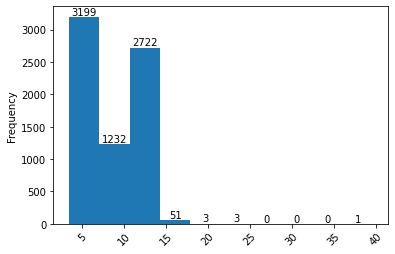

In [3]:
from matplotlib import pyplot as plt
import pandas as pd

stats = pd.read_csv('tgresponse/AtomResult.csv')[['id','label']]
ax = stats.label.plot.hist(rot=45)#, color=['r','g'])
ax.bar_label(ax.containers[0])
plt.show()

tg.assemble_data()

In [4]:
verts = pd.read_csv('tgresponse/vertices.csv').groupby('graph_id').get_group(0)
f = [x.replace('[','').replace(']','').replace(',','').split() for x in verts.features.to_numpy()]
np.array(f).astype(np.float32)

array([[ 0.5    ,  2.89614,  0.29558,  0.29558,  0.29559,  0.29558,
         0.29559,  2.89614,  0.29558],
       [ 0.29558,  0.29558,  2.89612,  0.29558,  0.5    ,  0.29559,
         0.29559,  2.89612,  0.29558],
       [ 0.29559,  0.29559,  0.29559,  2.89608,  0.29559,  0.29559,
         0.5    ,  2.89608,  0.29559],
       [ 2.89614,  2.89612,  2.89608,  2.89614, 36.8581 ,  2.89612,
         2.89612,  2.89608,  2.89612],
       [ 0.29558,  0.29558,  0.29559,  2.89612,  0.29558,  2.89612,
         0.29559,  0.5    ,  0.29558]], dtype=float32)

In [5]:
#DATASET
import dgl,torch
from dgl.data import DGLDataset

class QM7bDataset(DGLDataset):
	def __init__(self, **kwargs):
		super().__init__(**kwargs)

	def __getitem__(self, i):
		return self.graphs[i], self.labels[i]

	def __len__(self):
		return len(self.graphs)

	@staticmethod
	def mask_to_weights(mask):
			return mask.astype(np.int8) / np.count_nonzero(mask) #todo what does the division do?
	
	@property
	def num_classes(self):
			return self._num_classes
			
	def process(self):
		ego_verts = pd.read_csv('tgresponse/vertices.csv').dropna()# get verts that hold the graph's label
		edges = pd.read_csv('tgresponse/edges.csv')
		self.graphs = []
		self.labels = []

		# Create a graph for each graph ID from the edges table.
		# First process the properties table into two dictionaries with graph IDs as keys.
		# The label and number of nodes are values.
		label_dict = {}
		for _, row in tqdm(ego_verts.iterrows(), desc='building labels dict'):
			label_dict[row['graph_id']] = row['label']
		# For the edges, first group the table by graph IDs.
		edges_group = edges.groupby('graph_id')
		verts = pd.read_csv('tgresponse/vertices.csv').groupby('graph_id')

		# For each graph ID...
		for graph_id in tqdm(edges_group.groups, desc='assemble graphs'):
			# Find the edges as well as the number of nodes and its label.
			edges_of_id = edges_group.get_group(graph_id)
			dgl_id = {k:v for v,k in enumerate(np.unique(edges_of_id[['src','tgt']].to_numpy().flatten()))}
			edges_of_id['dgl_src'] = [dgl_id[i] for i in edges_of_id.src]
			edges_of_id['dgl_tgt'] = [dgl_id[i] for i in edges_of_id.tgt]
			src = edges_of_id['dgl_src'].to_numpy()
			dst = edges_of_id['dgl_tgt'].to_numpy()
			label = label_dict[graph_id]

			# Create a graph and add it to the list of graphs and labels.
			g = dgl.graph((src, dst), num_nodes=len(dgl_id.keys()))
			f = [x.replace('[','').replace(']','').replace(',','').split()[:5] for x in verts.get_group(graph_id).features.to_numpy()] # shortened to first five for the sake of the example
			assert all([len(x) == 5 for x in f])
			vertex_vectors = torch.from_numpy(np.array(f).astype(np.float32))
			g.ndata['x'] = vertex_vectors
					
			self.graphs.append(g)
			self.labels.append(label)

		# Convert the label list to tensor for saving.
		self.labels = torch.tensor(self.labels)

building labels dict: 7211it [00:00, 69817.93it/s]
assemble graphs: 100%|██████████| 7211/7211 [00:05<00:00, 1280.72it/s]


tensor(39.6946)
5
{'x': tensor([[ 0.5000,  2.8961,  0.2956,  0.2956,  0.2956],
        [ 0.2956,  0.2956,  2.8961,  0.2956,  0.5000],
        [ 0.2956,  0.2956,  0.2956,  2.8961,  0.2956],
        [ 2.8961,  2.8961,  2.8961,  2.8961, 36.8581],
        [ 0.2956,  0.2956,  0.2956,  2.8961,  0.2956]])}


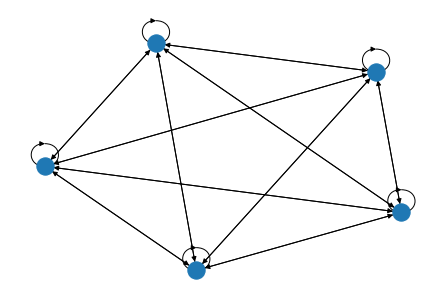

In [6]:
dataset = QM7bDataset(name='qm7b')
g, l = dataset[0]
print(l)
print(len(g.ndata['x']))
print(g.ndata)
import networkx as nx
nx.draw(g.to_networkx())

In [7]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)
batch_size = 64

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=batch_size, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False)

next(zip(train_dataloader,test_dataloader))

([Graph(num_nodes=1011, num_edges=16391,
        ndata_schemes={'x': Scheme(shape=(5,), dtype=torch.float32)}
        edata_schemes={}),
  tensor([11.9605, 10.8820, 13.4902, 10.8093, 11.9436,  6.2418, 13.3099,  6.1217,
          10.5464, 12.1520,  5.4356, 11.1596,  6.2142,  4.9817,  9.7066,  6.9585,
           6.7619, 12.2804,  5.7693,  6.0730, 10.3281,  6.0868, 11.2457, 11.9168,
           5.8796, 10.7043, 11.9300,  6.0618,  7.1222,  8.1092, 11.0069,  4.1850,
           6.7275, 10.7365, 12.8729, 10.8061,  6.2038,  6.2246, 11.6893,  5.2409,
          10.8515,  6.0221,  6.4399, 10.3091,  4.6065,  5.6875,  6.3326, 11.2987,
           6.6212,  6.4393, 10.4603, 11.5596, 10.4650, 11.4587, 10.7091, 12.2154,
           6.5319,  5.8778,  6.2536, 10.7931, 11.6818, 10.0966, 10.4344,  6.8347])],
 [Graph(num_nodes=927, num_edges=13759,
        ndata_schemes={'x': Scheme(shape=(5,), dtype=torch.float32)}
        edata_schemes={}),
  tensor([ 6.2259, 10.7453, 11.0927,  5.3174, 10.8376,  6.5035,  4.7

In [8]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

class qm7b_demo(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(qm7b_demo, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        # dglnn.GATv2Conv
        self.out = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h):
        # Apply graph convolution and activation.
        h = F.dropout(h)
        h = self.conv1(g, h)
        h = F.leaky_relu(h)
        h = F.dropout(h)
        h = self.conv2(g, h)
        h = F.leaky_relu(h)
        
        with g.local_scope():
            g.ndata['x'] = h
            # Calculate graph representation by average readout.
            hg = dgl.mean_nodes(g, 'x')
            return self.out(hg)

In [9]:
import numpy as np
def train(tr_dataloader, test_dataloader, model):
	learning_rate = 1e-2

	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

	history = []
	for e in range(100):
		t = tqdm(tr_dataloader, unit='batch')
		t.desc = f'Epoch {e}'
		for batched_graph, labels in t:
			features = batched_graph.ndata['x']
			# Forward
			y_ = model(batched_graph, features)
			loss = F.mse_loss(y_, labels)
			# Backward
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
	
			t.set_postfix(loss=loss.item())
		
		for batched_graph, labels in test_dataloader:
			features = batched_graph.ndata['x']
			testy_ = model(batched_graph, features)
			test_loss = F.mse_loss(testy_, labels)

		history.append([
				loss.item(),
				test_loss.item()
		])	
		
	return history

model = qm7b_demo(5, 20, 1)
history = train(train_dataloader, test_dataloader, model)

Epoch 99: 100%|██████████| 91/91 [00:00<00:00, 175.64batch/s, loss=7.41]


loss         float64
test_loss    float64
dtype: object


<AxesSubplot:>

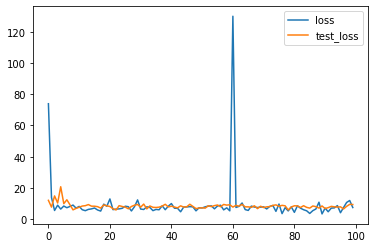

In [10]:
import pandas as pd
# df = pd.DataFrame(history, columns=['train_acc','val_acc','loss','val_loss', 'test_acc'])
df = pd.DataFrame(history, columns=['loss','test_loss'])
print(df.dtypes)
df[['loss','test_loss']].plot()
# df[['train_acc','val_acc','test_acc']].plot()

In [12]:
res = []
for batched_graph, labels in test_dataloader:
	features = batched_graph.ndata['x']
	testy_ = model(batched_graph, features)
	for l,lp in zip(labels.detach().numpy(),testy_.detach().numpy()):
		res.append([l,lp.item()])

pd.DataFrame(res,columns=['y',"y'"])

,y,y'
0,5.69888,8.941153
1,10.64824,8.930571
2,11.29453,8.949226
3,8.18008,8.916250
4,6.50114,8.923170
...,...,...
1438,10.89779,8.990242
1439,11.84602,8.948336
1440,11.31095,8.943125
1441,4.75800,8.933208
